In [208]:
import numpy
import xarray
import matplotlib.pyplot as mp
import glob
import pandas
import cartopy
import itertools
#import tqdm
import netCDF4

%matplotlib inline

In [216]:
PRECT_orig = '/scratch/blangenb/NCAR_LENS/PRECT/b.e11.B1850C5CN.f09_g16.005.cam.h1.PRECT.04020101-04991231.nc'
PRECT_orig_ds = xarray.open_dataset(PRECT_orig)
lat_full = PRECT_orig_ds['lat'].values
lon_full = PRECT_orig_ds['lon'].values

/export/home/blangenb/miniconda3/lib/python3.6/site-packages/xarray/coding/times.py:132: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy cftime.datetime objects instead, reason: dates out of range
  enable_cftimeindex)
/export/home/blangenb/miniconda3/lib/python3.6/site-packages/xarray/coding/variables.py:69: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy cftime.datetime objects instead, reason: dates out of range
  return self.func(self.array)


In [217]:
#PRECT_root = '/ninad/NCAR_LENS/PRECT/'
PRECT_root = '/scratch/blangenb/NCAR_LENS/PRECT_lonslices/'
#PRECT_root =  '/glade/p_old/cesmLE/CESM-CAM5-BGC-LE/atm/proc/tseries/daily/PRECT/'

In [225]:
file_list = sorted(glob.glob(PRECT_root+'/*.nc'))[:-1]

In [226]:
file_list[-1]

'/scratch/blangenb/NCAR_LENS/PRECT_lonslices/b.e11.B1850C5CN.f09_g16.005.cam.h1.PRECT.04020101-22001231.longitude223.nc'

In [227]:
# lon_qtr = int(288/4)
# lat_qtr = int(192/4)
# lon_half = int(288/2)
# lat_half = int(192/2)

lon_size = 288
lat_size = 192

Steps?

1. Open a single data set (one longitude slice)
2. Calculate the important things:
  * PIC daily 200 year return intervals
  * 100 year return interval
  * 50, 20 year return interval
  * 30- and 10-day running sum return intervals
  * Break into annual means for ONDJFM and AMJJAS, take mean, calculate 3-year droughts
  * Also calculate length of time of droughts...

In [228]:
# do all this for the first lon box to get the time and lat/lon information
lon_idx = 0
prect_pic_ds = xarray.open_mfdataset(file_list[0], decode_times=False)

prect_pic = prect_pic_ds['PRECT']*86400.*1000.
lon = prect_pic_ds['lon']
lat = prect_pic_ds['lat']
time_var = prect_pic_ds['time']
time = prect_pic_ds['time'].values

time_datetime = netCDF4.num2date(time, time_var.units, time_var.calendar)

# get dates corresponding to ONDJFM
# time_datetime = numpy.copy(time) #pandas.to_datetime(time)
time_seas_indices = [d.month in [10,11,12,1,2,3] for d in time_datetime]; SEAS_name = 'ONDJFM'
#time_seas_indices = [d.month in [4,5,6,7,8,9] for d in time_datetime]; SEAS_name = 'AMJJAS'
time_seas_datetime = time_datetime[time_seas_indices]

In [229]:
return_period = 100 # in years

for lon_idx in [194]:#range(195,file_list.__len__()):
    #[0]:#enumerate(file_list):#range(file_enumerate(file_list):
    
    prect_pic_ds = xarray.open_dataset(file_list[lon_idx], decode_times=False)
    prect_pic = prect_pic_ds['PRECT']*86400.*1000.
    prect_pic_data = prect_pic.values

    # set all <0.1 equal to zero (~15 seconds)

    prect_pic_data[prect_pic_data<0.1] = 0

    # take rolling mean (~3 minutes)

    window_size = 10
    prect_pic_data_rolling10 = numpy.zeros((prect_pic.shape))
    for j in range(lat.size):
        prect_pic_data_rolling10[:,j] = pandas.Series(prect_pic_data[:,j]).rolling(window=window_size).sum()

    window_size = 30
    prect_pic_data_rolling30 = numpy.zeros((prect_pic.shape))
    for j in range(lat.size):
        prect_pic_data_rolling30[:,j] = pandas.Series(prect_pic_data[:,j]).rolling(window=window_size).sum()

    # subset seasonal information
    prect_pic_seas_data = prect_pic_data[time_seas_indices,:]
    prect_pic_seas_data_rolling10 = prect_pic_data_rolling10[time_seas_indices,:]
    prect_pic_seas_data_rolling30 = prect_pic_data_rolling30[time_seas_indices,:]
    
    # now caculate return period information
    events_per_year = 180
    return_val_perc = 100*(1-1/(return_period*events_per_year))
    print(return_val_perc)
    percentile_values = numpy.zeros((lat.size))
    for j in range(lat.size):
        tmp_distro = prect_pic_seas_data[:,j]
        percentile_values[j] = numpy.nanpercentile(tmp_distro, return_val_perc)
    SAVE_name = '/scratch/blangenb/NCAR_LENS/PRECT_lonslices_processed/' + SEAS_name + \
    '_pic_'+str(return_period)+'yr_return_period_daily_longitude'+'{:03d}'.format(lon_idx+1)+'.npy'
    numpy.save(SAVE_name, percentile_values)
    
    # for 10-day sums
    events_per_year = 180/10
    return_val_perc = 100*(1-1/(return_period*events_per_year))
    print(return_val_perc)
    percentile_values = numpy.zeros((lat.size))
    for j in range(lat.size):
        tmp_distro = prect_pic_data_rolling10[:,j]
        percentile_values[j] = numpy.nanpercentile(tmp_distro, return_val_perc)
    SAVE_name = '/scratch/blangenb/NCAR_LENS/PRECT_lonslices_processed/' + SEAS_name + \
    '_pic_'+str(return_period)+'yr_return_period_10daysum_longitude'+'{:03d}'.format(lon_idx+1)+'.npy'
    numpy.save(SAVE_name, percentile_values)

    # for 10-day sums
    events_per_year = 180/30
    return_val_perc = 100*(1-1/(return_period*events_per_year))
    print(return_val_perc)
    percentile_values = numpy.zeros((lat.size))
    for j in range(lat.size):
        tmp_distro = prect_pic_data_rolling30[:,j]
        percentile_values[j] = numpy.nanpercentile(tmp_distro, return_val_perc)
    SAVE_name = '/scratch/blangenb/NCAR_LENS/PRECT_lonslices_processed/' + SEAS_name + \
    '_pic_'+str(return_period)+'yr_return_period_30daysum_longitude'+'{:03d}'.format(lon_idx+1)+'.npy'
    numpy.save(SAVE_name, percentile_values)
    print(SAVE_name)

99.99444444444444
99.94444444444444
99.83333333333333
/scratch/blangenb/NCAR_LENS/PRECT_lonslices_processed/ONDJFM_pic_100yr_return_period_30daysum_longitude195.npy


also need code to calculate seasonal totals

In [194]:
output_file_list = sorted(glob.glob('/scratch/blangenb/NCAR_LENS/PRECT_lonslices_processed/AMJJAS_pic_100yr_return_period_daily*'))

In [195]:
output_file_list[-20:]

['/scratch/blangenb/NCAR_LENS/PRECT_lonslices_processed/ONDJFM_pic_100yr_return_period_daily_longitude169.npy',
 '/scratch/blangenb/NCAR_LENS/PRECT_lonslices_processed/ONDJFM_pic_100yr_return_period_daily_longitude170.npy',
 '/scratch/blangenb/NCAR_LENS/PRECT_lonslices_processed/ONDJFM_pic_100yr_return_period_daily_longitude171.npy',
 '/scratch/blangenb/NCAR_LENS/PRECT_lonslices_processed/ONDJFM_pic_100yr_return_period_daily_longitude172.npy',
 '/scratch/blangenb/NCAR_LENS/PRECT_lonslices_processed/ONDJFM_pic_100yr_return_period_daily_longitude173.npy',
 '/scratch/blangenb/NCAR_LENS/PRECT_lonslices_processed/ONDJFM_pic_100yr_return_period_daily_longitude174.npy',
 '/scratch/blangenb/NCAR_LENS/PRECT_lonslices_processed/ONDJFM_pic_100yr_return_period_daily_longitude175.npy',
 '/scratch/blangenb/NCAR_LENS/PRECT_lonslices_processed/ONDJFM_pic_100yr_return_period_daily_longitude176.npy',
 '/scratch/blangenb/NCAR_LENS/PRECT_lonslices_processed/ONDJFM_pic_100yr_return_period_daily_longitude17

In [196]:
file_tmp = numpy.load(output_file_list[0])
daily_100yr_ri_pic = numpy.zeros((file_tmp.size,output_file_list.__len__()))
for i,file in enumerate(output_file_list):
    daily_100yr_ri_pic[:,i] = numpy.load(file)
#for file in output_file_list:

In [197]:
output_file_list[-1]

'/scratch/blangenb/NCAR_LENS/PRECT_lonslices_processed/ONDJFM_pic_100yr_return_period_daily_longitude188.npy'

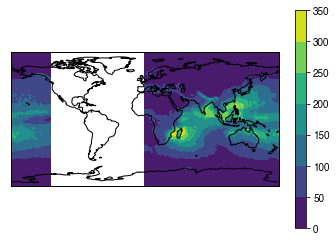

In [198]:
fig = mp.figure()
ax = fig.add_subplot(111, projection=cartopy.crs.PlateCarree())
plot = ax.contourf(lon_full[list(range(output_file_list.__len__()))],lat_full,daily_100yr_ri_pic)
ax.coastlines()
mp.colorbar(plot)

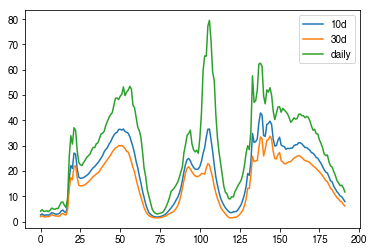

In [140]:
mp.plot(a, label='10d')
mp.plot(b, label='30d')
mp.plot(c, label='daily')
mp.legend()

In [118]:
'/scratch/blangenb/NCAR_LENS/PRECT_lonslices_processed/' + SEAS_name + \
    '_pic_'+str(return_period)+'yr_return_period_longitude'+'{:03d}'.format(lon_idx+1)+'.nc'

'/scratch/blangenb/NCAR_LENS/PRECT_lonslices_processed/ONDJFM_pic_200yr_return_period_longitude001.nc'

for checking memory usage

In [ ]:
# get dates corresponding to ONDJFM

# time_datetime = numpy.copy(time) #pandas.to_datetime(time)
time_seas_indices = [d.month in [10,11,12,1,2,3] for d in time_datetime]; SEAS_name = 'ONDJFM'
time_seas_datetime = time_datetime[time_seas_indices]

# step below takes about 15 MINUTES

prect_pic_data = prect_pic.values

# set all <0.1 equal to zero (~15 seconds)

prect_pic_data[prect_pic_data<0.1] = 0

# take rolling mean (~3 minutes)

window_size = 10
prect_pic_data_rolling10 = numpy.zeros((prect_pic.shape))
for j in range(lat.size):
    prect_pic_data_rolling10[:,j] = pandas.Series(prect_pic_data[:,j]).rolling(window=window_size).sum()

window_size = 30
prect_pic_data_rolling30 = numpy.zeros((prect_pic.shape))
for j in range(lat.size):
    prect_pic_data_rolling30[:,j] = pandas.Series(prect_pic_data[:,j]).rolling(window=window_size).sum()

prect_pic_seas_data = prect_pic_data[time_seas_indices,:]
prect_pic_seas_data_rolling10 = prect_pic_data_rolling10[time_seas_indices,:]
prect_pic_seas_data_rolling30 = prect_pic_data_rolling30[time_seas_indices,:]

## do calculations for DRY periods

1. loop through all years, calculate the mean of each year for the given season
2. once you do that, string together means and calculate the 3-year running mean
3. then do statistics on that distribution

In [75]:
nyears = time_seas_datetime[-1].year - time_seas_datetime[0].year + 1
year_values = [y for y in range(time_seas_datetime[0].year, time_seas_datetime[-1].year+1, 1)]

takes 42 minutes to do this...

In [86]:
prect_pic_seas_data_annualmeans = numpy.zeros((nyears,lat.size))

for y,year in enumerate(year_values):
    if year%50==0:
        print(year)
    year_indices = [t.year==year for t in time_seas_datetime]
    for j in range(lat.size):
        prect_pic_seas_data_annualmeans[y,j] = numpy.nanmean(prect_pic_seas_data[year_indices,j])

SAVE_name = '/scratch/blangenb/NCAR_LENS/PRECT_lonslices_processed/' + SEAS_name+'_pic_annual_mean_longitude'+'{:03d}'.format(lon_idx+1)+'.nc'
numpy.save(SAVE_name, prect_pic_seas_data_annualmeans)

450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
1500
1550
1600
1650
1700
1750
1800
1850
1900
1950
2000
2050
2100
2150
2200


In [ ]:
window_size = 3
prect_pic_data_rolling3yr = numpy.zeros((prect_pic_seas_data_annualmeans.shape))
for j in range(lat.size):
    prect_pic_data_rolling3yr[:,j] = pandas.Series(prect_pic_data[:,j]).rolling(window=window_size).sum()

# extreme high precipitation calculations

specify return period below

In [57]:
return_period = 200 # in years

percentile values for daily precip

In [58]:
events_per_year = 151
return_val_perc = 100*(1-1/(return_period*events_per_year))
print(return_val_perc)

percentile_values = numpy.zeros((lat.size))
for j in range(lat.size):
    # get rid of nans
    tmp_distro = prect_pic_seas_data[:,j]
    #prect_djf[:,j,k][~numpy.isnan(prect_djf[:,j,k])]
    percentile_values[j] = numpy.nanpercentile(tmp_distro, return_val_perc)

99.99668874172185


percentile values for 10-day precip sums

In [59]:
events_per_year = 151/10
return_val_perc = 100*(1-1/(return_period*events_per_year))
print(return_val_perc)

percentile_values = numpy.zeros((lat.size))
for j in range(lat.size):
    # get rid of nans
    tmp_distro = prect_pic_seas_data_rolling10[:,j]
    percentile_values[j] = numpy.nanpercentile(tmp_distro, return_val_perc)

99.96688741721854


percentile values for 30-day precip sums

In [60]:
events_per_year = 151/30
return_val_perc = 100*(1-1/(return_period*events_per_year))
print(return_val_perc)

percentile_values = numpy.zeros((lat.size))
for j in range(lat.size):
    # get rid of nans
    tmp_distro = prect_pic_seas_data_rolling30[:,j]
    #prect_djf[:,j,k][~numpy.isnan(prect_djf[:,j,k])]
    percentile_values[j] = numpy.nanpercentile(tmp_distro, return_val_perc)

99.90066225165563


In [ ]:
# saveas info
file_prefix = 'LL_pic_daily_200yr_wet'
numpy.save('../intermediate-files/file_prefix' + '.npy', percentile_values)

In [ ]:
proj_map = cartopy.crs.PlateCarree()

fig = mp.figure(figsize=(10,10))

ax = fig.add_subplot(111, projection=proj_map)
ax.coastlines(resolution='50m')
plot = ax.contourf(lon, lat, percentile_values)
mp.colorbar(plot)
ax.set_global()
#ax.set_extent([-130,-100,20,55])
#ax.set_extent([-150,-80,10,70])